In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras

from scipy.stats import probplot
from scipy.stats import normaltest

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [3]:
inferenceLocations = ['Beaglebone','Amazon-EC2']
vibSamples = ['4096','8192','16384','32768','65536']
vibSampleLabels = [r'$2^{12}$',r'$2^{13}$',r'$2^{14}$',r'$2^{15}$',r'$2^{16}$']
vibSampleLabels = [r'4.10',r'8.19',r'16.4',r'32.8',r'65.5']

basePath = 'Edge-Device-Latency/'
modelId = 'CNN-AE-Lite'
deviceId = 'Amazon-EC2'
numSamples = 1000
numColumns = 3

latencyVals = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
columns = None

In [4]:
for i in range(len(vibSamples)):
    for j in range(len(inferenceLocations)):
        thisDF = pd.read_csv(basePath + inferenceLocations[j] +'_' + modelId + '_' + vibSamples[i] + '.csv')

        print(thisDF.values.shape)


        latencyVals[:,j,i] = np.sum(thisDF.values[-numSamples:,:],axis=1)



(1005, 3)
(1001, 3)
(1001, 3)
(1163, 3)
(1001, 3)
(1001, 3)
(1001, 3)
(1001, 3)
(1001, 3)
(1001, 3)


mean latency, max latency, Max Score Difference, MSE

In [5]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,plot_type='box'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()

    if plot_type == 'box':

        bp = plt.boxplot(data,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2})
        ax = plt.gca()

        for patch, color in zip(bp['boxes'], thisColors):
            # change outline color
            patch.set(color=color, linewidth=2)
            patch.set_facecolor(color)
    else:
        violin_parts = plt.violinplot(data,
                  showmeans=False,
                  showmedians=False,
                  showextrema=False)
        ax = plt.gca()
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_edgecolor('black')

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    
    

def box_plot_compare(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(data.shape[1])]
    tickPositions = []
    phantomLines = []
        
    for i in range(data.shape[-1]):
        
        max_index = data.shape[0] - max_cutoff
        min_index = min_cutoff
        
        thisData = np.sort(data[...,i],axis=0)[min_index:max_index,:]
  
        violin_parts = plt.violinplot(thisData,
                  positions = position,
                  showmeans=False,
                  showmedians=False,
                  showextrema=False)
        
        tickPositions.append(np.mean(position))

        for counter, pc in enumerate(violin_parts['bodies']):
            pc.set_facecolor(colors[counter])
            pc.set_edgecolor('black')
            pc.set_alpha(1)
            
            if i == 0:
                line, = plt.plot([1,1],color=colors[counter])
                phantomLines.append(line)
            
        position = [position[i] + data.shape[1] + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    print(tickPositions)
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(inferenceLocations),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

In [6]:
np.sort(latencyVals[...,0],axis=0)[:1000,:].shape

(1000, 2)

In [7]:
latencyVals.shape

(1000, 2, 5)

In [8]:
print(np.percentile(latencyVals,99,axis=0))
print(np.percentile(latencyVals,95,axis=0))
print(np.percentile(latencyVals,50,axis=0))

[[2847.02 3106.17 3568.01 4471.   6370.02]
 [3563.08 3651.1  3878.39 4458.04 5341.26]]
[[2595.2  3034.2  3514.1  4422.   6297.95]
 [3093.   3178.15 3422.45 3964.1  4961.05]]
[[2497.  2728.  3185.  4096.5 5925.5]
 [2342.  2433.  2638.  3206.  4120.5]]


[1.5, 4.5, 7.5, 10.5, 13.5]


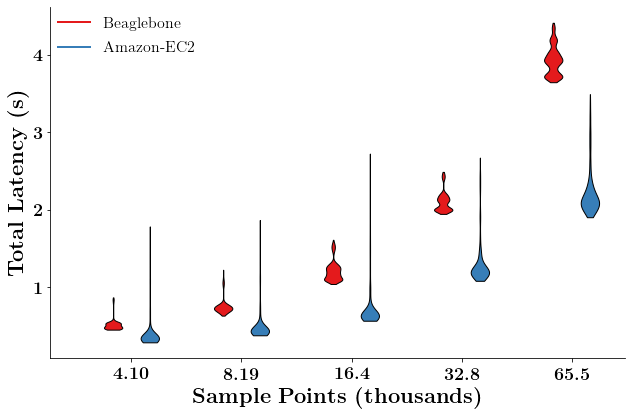

In [9]:
box_plot_compare((latencyVals-2000)/1000,vibSampleLabels,savefig=True,filename=inferenceLocations[0] + '_TotalLatency_' + modelId,
         template='presentation',xlabel='Sample Points (thousands)',color_order=np.zeros(6).astype(int),ylabel='Total Latency (s)',
         showfliers=True,legend_loc='upper left',max_cutoff=2,
         log_y=False)

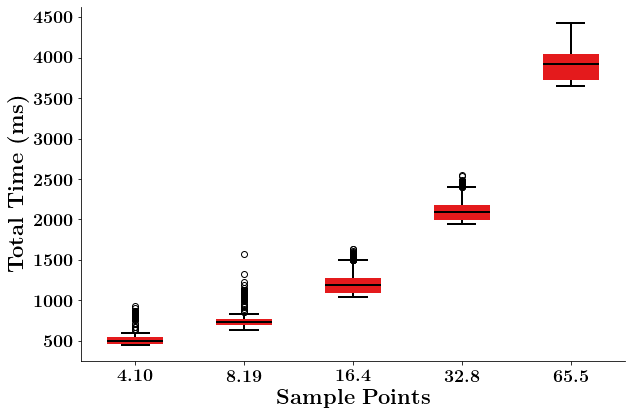

IndexError: index 2 is out of bounds for axis 1 with size 2

In [10]:
# box_plot(latencyVals[:,0,:] - 2000,vibSampleLabels,savefig=True,filename=deviceId + '_SampleLatency_' + modelId,
#          template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int))
# box_plot(latencyVals[:,1,:],vibSampleLabels,savefig=True,filename=deviceId + '_FeatureExtractLatency_' + modelId,
#          template='Presentation',xlabel='Sample Points',xtickpad=10,color_order=np.zeros(6).astype(int))
# box_plot(latencyVals[:,2,:],vibSampleLabels,savefig=True,filename=deviceId + '_ModelInferenceLatency_' + modelId,
#          template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int))

box_plot(latencyVals[:,0,:] - 2000,vibSampleLabels,savefig=True,filename=inferenceLocations[0] + '_TotalLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Total Time (ms)',
         showfliers=True)


box_plot(latencyVals[:,2,:] - 2000,vibSampleLabels,savefig=True,filename=inferenceLocations[0] + '_TotalLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Total Time (ms)',
         showfliers=True,plot_type='box')

box_plot(latencyVals[:,1,:] - 2000,vibSampleLabels,savefig=True,filename=inferenceLocations[1] + '_TotalLatency_' + modelId,
         template='Presentation',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Total Time (ms)',
         showfliers=True)


In [11]:
print(np.amax(latencyVals[:,0,-1]))
print(np.amax(latencyVals[:,1,-1]))
print(np.amax(latencyVals[:,2,-1]))

6430.0
9388.0


IndexError: index 2 is out of bounds for axis 1 with size 2

In [12]:

box_plot(latencyVals[:,4,:],inferenceLocationsBold,savefig=True,filename='PCA-GNB_Boxplot')



box_plot(latencyVals[:,7,:],inferenceLocationsBold,savefig=True,filename='CNN-MLP-Lite_Boxplot')



IndexError: index 4 is out of bounds for axis 1 with size 2

In [13]:
latencyVals.shape

(1000, 2, 5)

In [14]:
def percent_increase(data,level):
    percentiles = np.percentile(data,level,axis=0)
    
    increase = (percentiles[0,:] - percentiles[1,:]) / (percentiles[0,:]) * 100
    
    return increase

In [15]:
print(np.percentile(latencyVals,99,axis=0))
print(np.percentile(latencyVals,95,axis=0))
print(np.percentile(latencyVals,50,axis=0))
percent_increase(latencyVals,50)

[[2847.02 3106.17 3568.01 4471.   6370.02]
 [3563.08 3651.1  3878.39 4458.04 5341.26]]
[[2595.2  3034.2  3514.1  4422.   6297.95]
 [3093.   3178.15 3422.45 3964.1  4961.05]]
[[2497.  2728.  3185.  4096.5 5925.5]
 [2342.  2433.  2638.  3206.  4120.5]]


array([ 6.20744894, 10.81378299, 17.17425432, 21.73806908, 30.46156442])

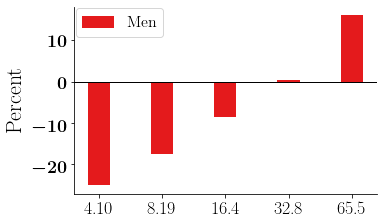

In [16]:
import numpy as np
import matplotlib.pyplot as plt


width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
ax = plt.gca()
plt.bar(vibSampleLabels, percent_increase(latencyVals,99), width, label='Men')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.axhline(y=0, color='k',linewidth=1)

ax.set_ylabel('Percent ')
ax.legend()

plt.show()

In [ ]:


def bar_chart_compare(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
    
    plt.bar(vibSampleLabels, data, width, label='Men')
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    print(tickPositions)
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(inferenceLocations),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()